In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from utilities import get_hashtags, clean_tweet, translate_emoji,  create_bank_col
#Reading data and models
import glob                     
import os
import pickle
import re
import numpy as np
import datetime as dt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nicholas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load parquet file
tweets_df = pd.read_parquet("tweets_from_2019-01-01_to_2019-01-02.parquet")

In [3]:
# show df info
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 0 to 39
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Datetime       405 non-null    datetime64[ns, UTC]
 1   Tweet_Id       405 non-null    int64              
 2   Tweet          405 non-null    string             
 3   Username       405 non-null    string             
 4   Reply_Count    405 non-null    int64              
 5   Retweet_Count  405 non-null    int64              
 6   Like_Count     405 non-null    int64              
 7   Bank           405 non-null    string             
dtypes: datetime64[ns, UTC](1), int64(4), string(3)
memory usage: 28.5 KB


In [4]:
# Show first 5 rows
tweets_df.head()

,Datetime,Tweet_Id,Tweet,Username,Reply_Count,Retweet_Count,Like_Count,Bank
0,2019-01-01 23:32:42+00:00,1080245458730184704,@SlowbucksAce Trippin 🤦🏽‍♂️ gotta give it to g...,fnb_justo,0,0,3,fnb
1,2019-01-01 22:36:31+00:00,1080231323552411650,"Fake news or nah, I needed to see that SMS fro...",BangDulamo_ZA,0,0,0,fnb
2,2019-01-01 22:29:20+00:00,1080229514712678400,Them Ⓜ️'s coming in I let 'em stack up 💰 Don't...,fnb_justo,0,1,11,fnb
3,2019-01-01 21:55:39+00:00,1080221037395169280,FNB is so annoying with their unauthorized deb...,babyLangah,0,0,0,fnb
4,2019-01-01 21:38:11+00:00,1080216641684819968,@hothaata Forget the critics let's start 2019 ...,NavasExpert,0,0,0,fnb


In [5]:
# remove rows where username is in bank_search
tweets_df = tweets_df[ ~tweets_df["Username"].str.lower().str.contains('fnb|standardbank|nedbank|absa|capitec',regex = True)]

<AxesSubplot: title={'center': 'Number of tweets per bank for 2010'}, xlabel='Bank', ylabel='Number of tweets'>

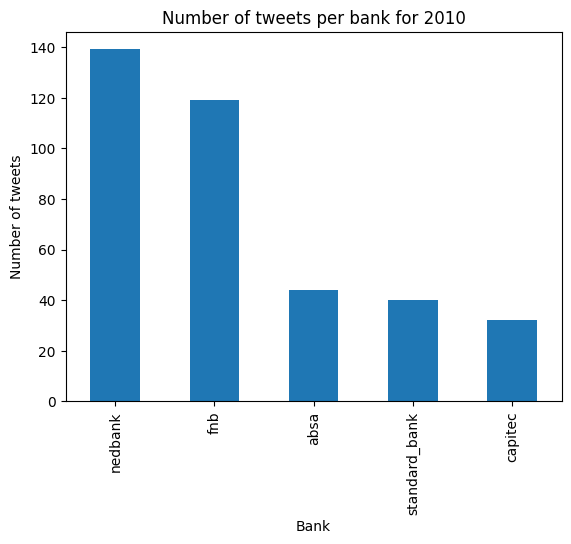

In [6]:
# Plot the number of tweets per bank the year 2010
tweets_df['Bank'].value_counts().plot(kind='bar', title='Number of tweets per bank for 2010', xlabel='Bank', ylabel='Number of tweets')

<AxesSubplot: title={'center': 'Number of likes per bank for 2010'}, xlabel='Bank', ylabel='Number of likes'>

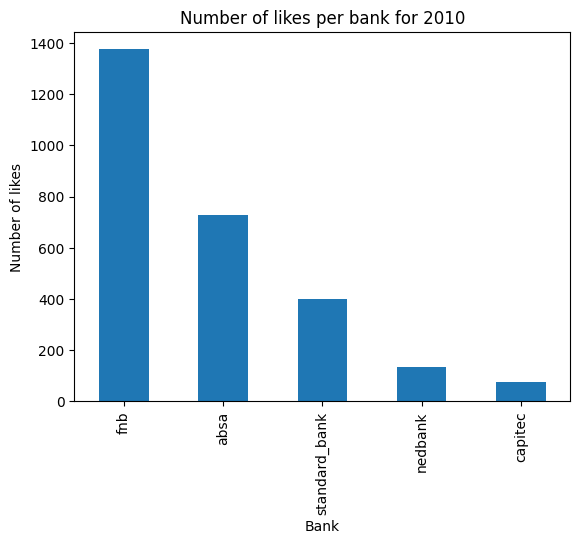

In [7]:
# plot the number of likes per bank for the year
tweets_df.groupby('Bank')['Like_Count'].sum().sort_values(ascending=False).plot(kind='bar', title='Number of likes per bank for 2010', xlabel='Bank', ylabel='Number of likes')

In [8]:
tweets_df['Tweet_clean'] = tweets_df['Tweet'].apply(translate_emoji).apply(clean_tweet)


In [11]:
tweets_df = tweets_df.astype({'Tweet_clean': 'string'})
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374 entries, 1 to 39
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   Datetime       374 non-null    datetime64[ns, UTC]
 1   Tweet_Id       374 non-null    int64              
 2   Tweet          374 non-null    string             
 3   Username       374 non-null    string             
 4   Reply_Count    374 non-null    int64              
 5   Retweet_Count  374 non-null    int64              
 6   Like_Count     374 non-null    int64              
 7   Bank           374 non-null    string             
 8   Tweet_clean    374 non-null    string             
dtypes: datetime64[ns, UTC](1), int64(4), string(4)
memory usage: 29.2 KB


In [14]:

tweets_df[['Tweet', 'Tweet_clean']].head(10)

,Tweet,Tweet_clean
1,"Fake news or nah, I needed to see that SMS fro...",fake news or nah i needed to see that sms from...
3,FNB is so annoying with their unauthorized deb...,fnb iso annoying witheir unauthorizedebit orde...
4,@hothaata Forget the critics let's start 2019 ...,forgethe critics let tart on a high january fn...
5,@MyChisha @Magzzy4 Lol the sequence is FNB mes...,lol the sequence is fnb messages zangena a lil...
8,"Lol, I check my FNB app everyday.",lol i check my fnb app everyday
9,🗣🗣🗣🗣Best all purpose player in the nation @H_H...,speaking headspeaking headbest all purpose pla...
10,Never seem so many digits in an FNB message 😭😭😭,never seem so many digits in an fnb message lo...
11,@Mkhu28 I'll be at the FNB stadium to witness ...,i ll be athe fnb stadium to witness the whole ...
13,"@cybermeow_ Like me, i started with fnb and it...",like me i started with fnb and it was depressi...
14,1st things 1st Planning starts with the diary ...,sthings st planning starts withe diary noteboo...


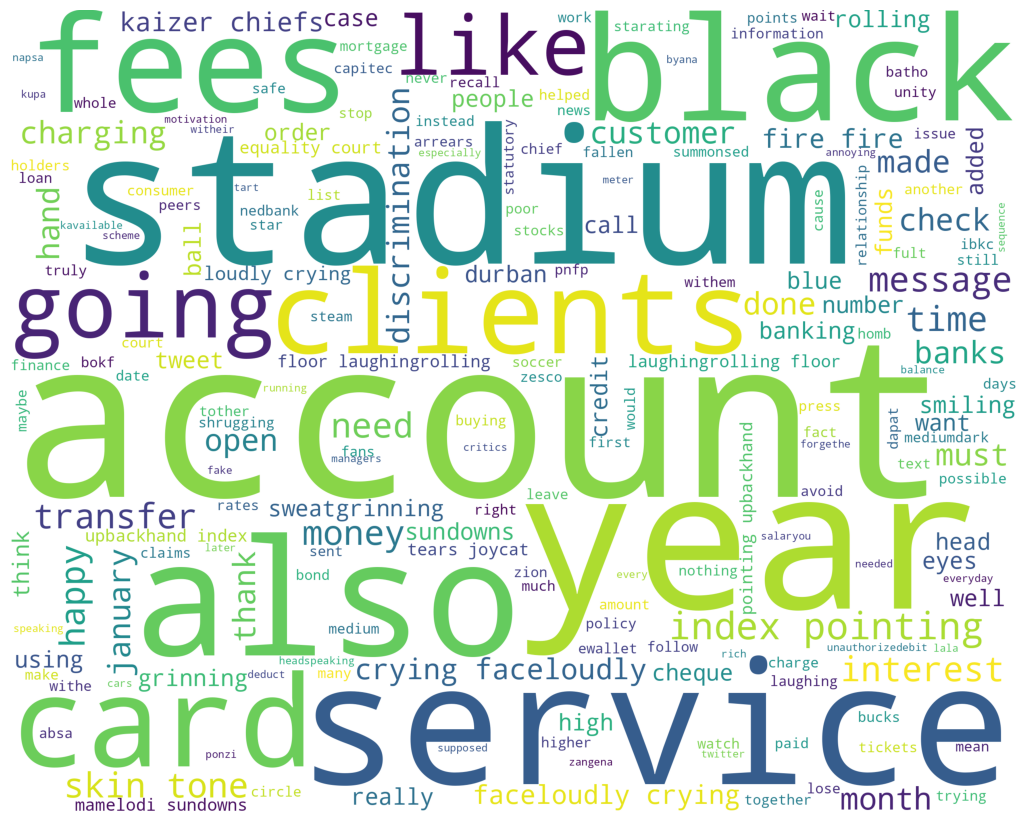

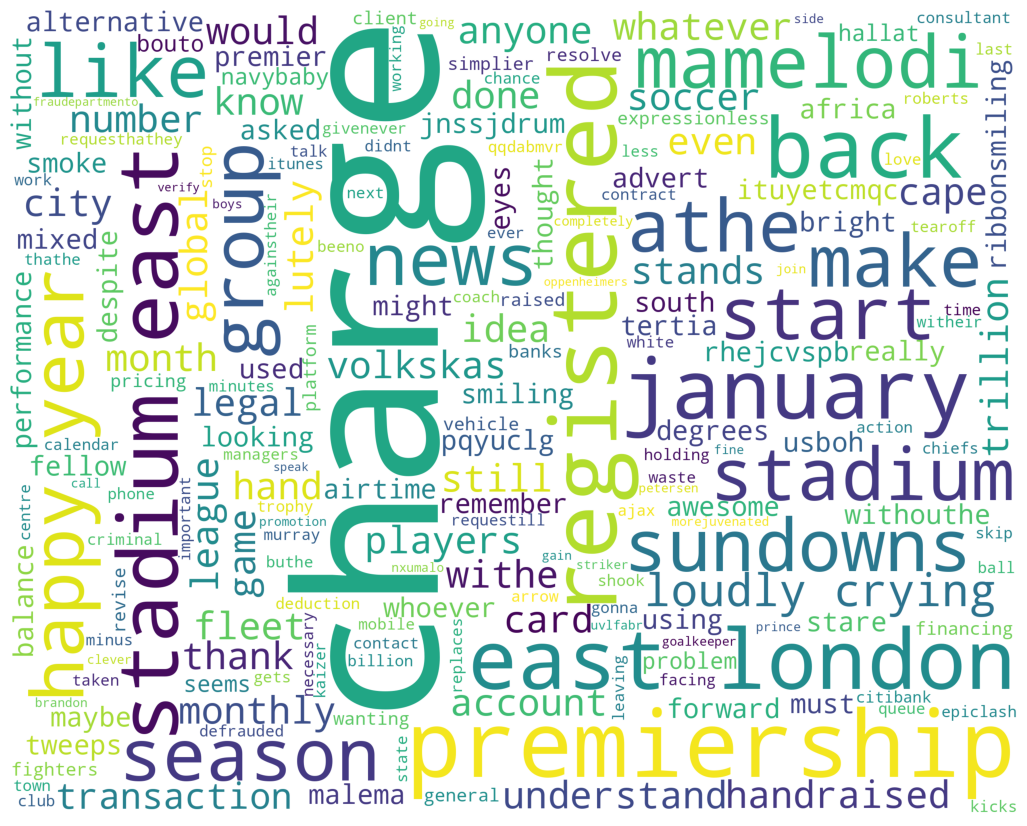

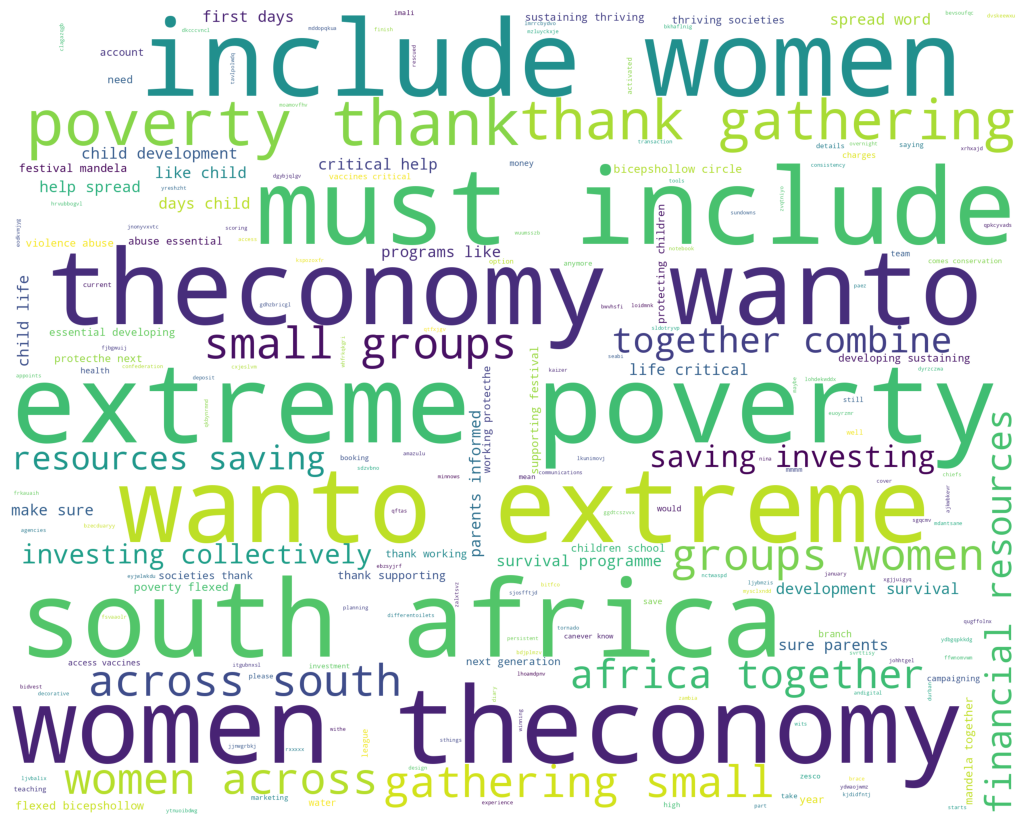

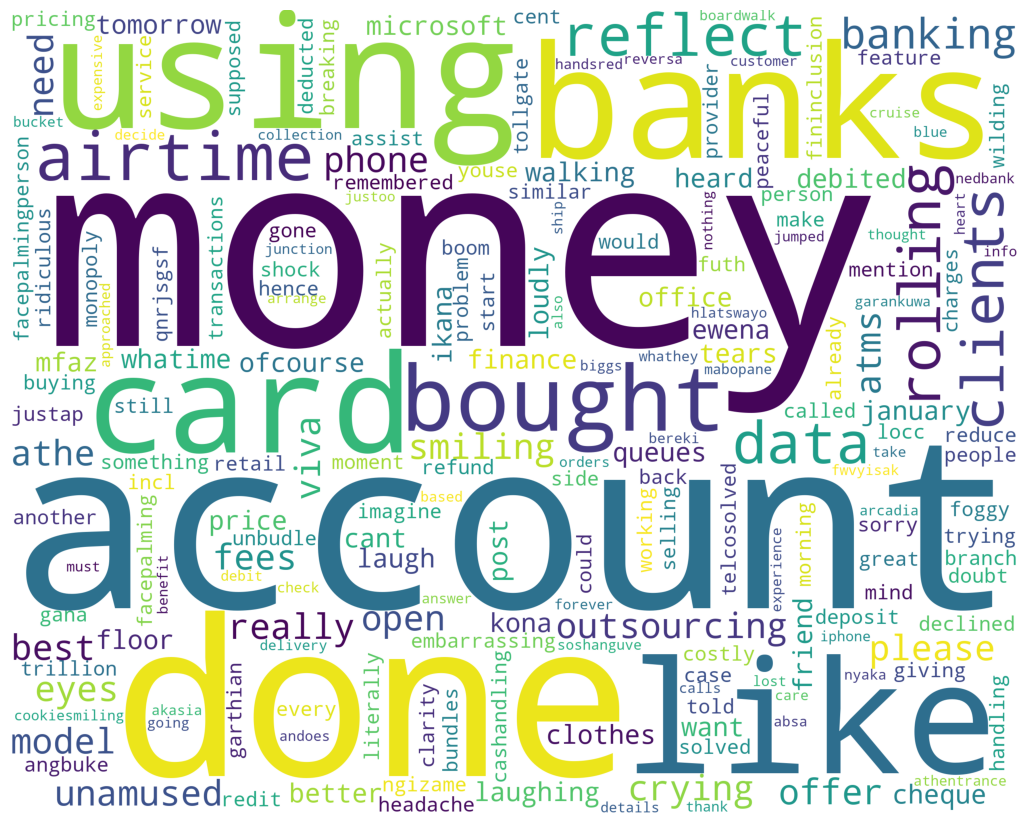

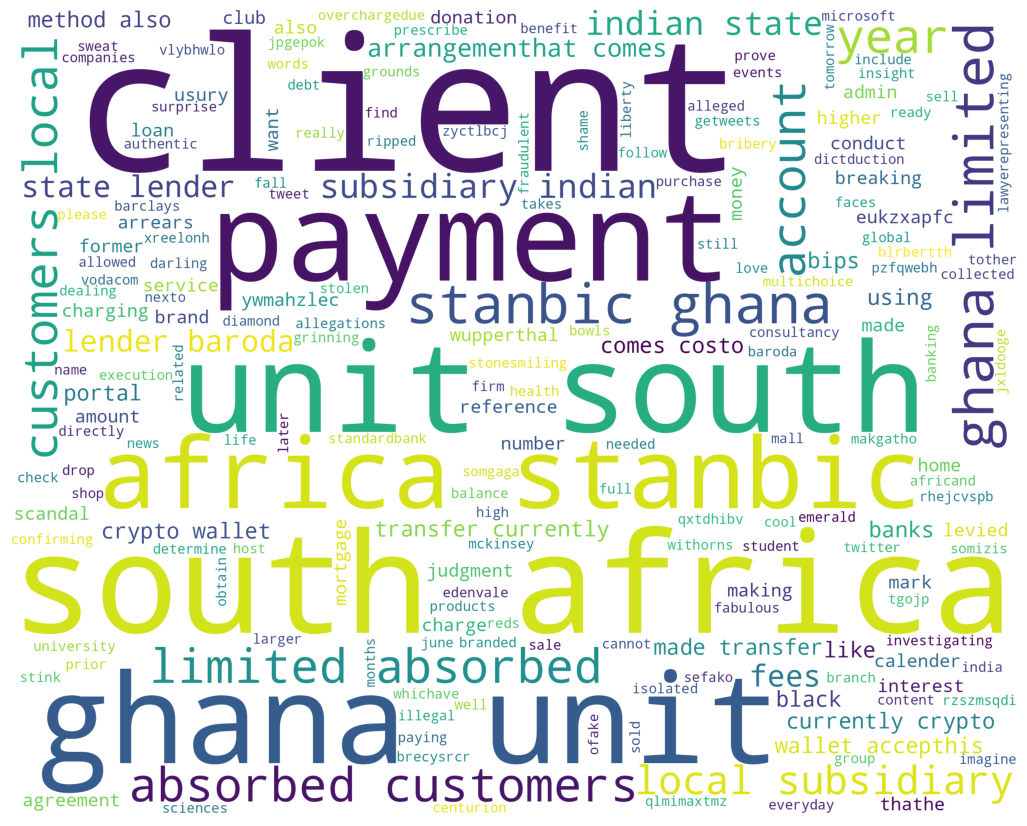

In [36]:


# word cloud for each bank using the clean tweets
for bank in tweets_df['Bank'].unique():
    bank_df = tweets_df[tweets_df['Bank'] == bank]
    words = ' '.join(bank_df['Tweet_clean'])
    words = re.sub(rf'{bank}', '', words)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'co'
                                and word != 'RT'
                                and word != 'standard bank'
                                and word != 'standard'
                                and word != 'bank'
                                and word != 'face'
                                # and not any word less than 3 characters
                                and len(word) > 3
                            ])
    wordcloud = WordCloud(
                          stopwords=stop_words,
                          background_color='white',
                          width=2500,
                          height=2000
                         ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [32]:
# query tweets with the word "face"
tweets_df[tweets_df['Tweet_clean'].str.contains('face')][['Tweet_clean']].head(10).values

array([['never seem so many digits in an fnb message loudly crying faceloudly crying faceloudly crying face'],
       ['i ll be athe fnb stadium to witness the whole thing kuzoba mnandi beaming face with smiling eyes'],
       ['like me i started with fnb and it was depressing but ended with fo and it was all great smiling face you did it gurl you canow have all the free time you want hundred pointshundred points'],
       ['before you even go to that fnb atm which number are you going to use grinning face with sweateyes'],
       ['this mood sums up how i feel abouthe following months going onwards firesmiling face with open handsyellow heartbackhand index pointing up medium skin tonegem stonesparklesconfetti ball also it the first match of the year vs kaizer chiefs soccer ball pm goal netfnb https t co bxcolom'],
       ['kaizer chiefs defender daniel cardoso says new head coach ernst middendorp has brought in a lot of positivenergy as amakhosi prepare to face mamelodi sundowns at fn